## 단국대 따릉이 대여량 

### train/test

- train : 2018-01-01 ~ 2020-12-31(3년치) (1095, 13) IN:2020-02-29, Out:2019-09-07
- test : 2021-01-01 ~ 2021-12-31(1년치) (365, 12)


### 독립변수
+ date: 날짜
+ precipitation: 강수량(mm)
+ temp_mean: 평균 기온(℃)
+ temp_highest: 최고 기온(℃)
+ temp_lowest: 최저 기온(℃)
+ PM10: 미세먼지(㎍/㎥)
+ PM2.5: 초미세먼지(㎍/㎥)
+ humidity: 습도(%rh)
+ sunshine_sum: 일조합
+ sunshine_rate: 일조율
+ wind_mean: 평균 풍속(m/s)
+ wind_max: 최대 풍속(m/s)

### 종속변수
+ rentals : 따릉이 대여량

In [68]:
y_test1 = pd.read_csv('./input/dankook/서울특별시 공공자전거 일별 대여건수_2020-07-01_2021-01-31.csv', encoding='cp949')[184:].drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
y_test2 = pd.read_csv('./input/dankook/서울특별시 공공자전거 일별 대여건수_21-02-01_21-06-30.csv', encoding='cp949')[:150].drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'])
y_test3 = pd.read_csv('./input/dankook/서울특별시 공공자전거 일별 대여건수_21-07~21-12.csv', encoding='cp949')[:184].drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'])

y_test = pd.concat([y_test1, y_test2, y_test3],axis=0)
y_test['대여건수'] = y_test['대여건수'].str.replace(',', '')
y_test['대여건수'].astype(int)
y_test.reset_index().drop(columns = 'index')
y_test.to_csv('./input/dankook/y_test.csv')

In [70]:
y_test = pd.read_csv('./input/dankook/y_test.csv')
y_test.drop(columns = 'Unnamed: 0')

대여일시   대여건수
0    2021-01-01  22274
1    2021-01-02  23631
2    2021-01-03  21809
3    2021-01-04  32957
4    2021-01-05  29033
..          ...    ...
360  2021-12-27  42521
361  2021-12-28  51268
362  2021-12-29  52017
363  2021-12-30  48993
364  2021-12-31  40604

[365 rows x 2 columns]

### 기본 정보

In [310]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

train = pd.read_csv('./input/dankook/train.csv')
test = pd.read_csv('./input/dankook/test.csv')
train.head()

date  precipitation  temp_mean  temp_highest  temp_lowest  PM10  \
0  2018-01-01            NaN       -1.3           3.8         -5.1  34.0   
1  2018-01-02            NaN       -1.8           1.8         -4.3  36.0   
2  2018-01-03            NaN       -4.7          -0.4         -7.1  31.0   
3  2018-01-04            NaN       -4.7          -0.7         -8.7  39.0   
4  2018-01-05            NaN       -3.0           1.6         -5.6  51.0   

   PM2.5  humidity  sunshine_sum  sunshine_rate  wind_mean  wind_max  rental  
0   17.0      39.1           8.3           86.5        1.4       3.8    4950  
1   22.0      42.0           7.9           82.3        1.8       4.9    7136  
2   19.0      42.3           8.6           88.7        2.2       3.5    7156  
3   24.0      43.0           6.2           63.9        1.4       3.5    7102  
4   35.0      48.4           8.2           84.5        1.7       3.6    7705

### 날짜 변환

In [311]:
def date_conv(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] =df['date'].dt.month
    df['month_day'] =df['date'].dt.strftime('%m-%d')
    df['week'] = df['date'].dt.weekday
    return df
    
train = date_conv(train)
test = date_conv(test)

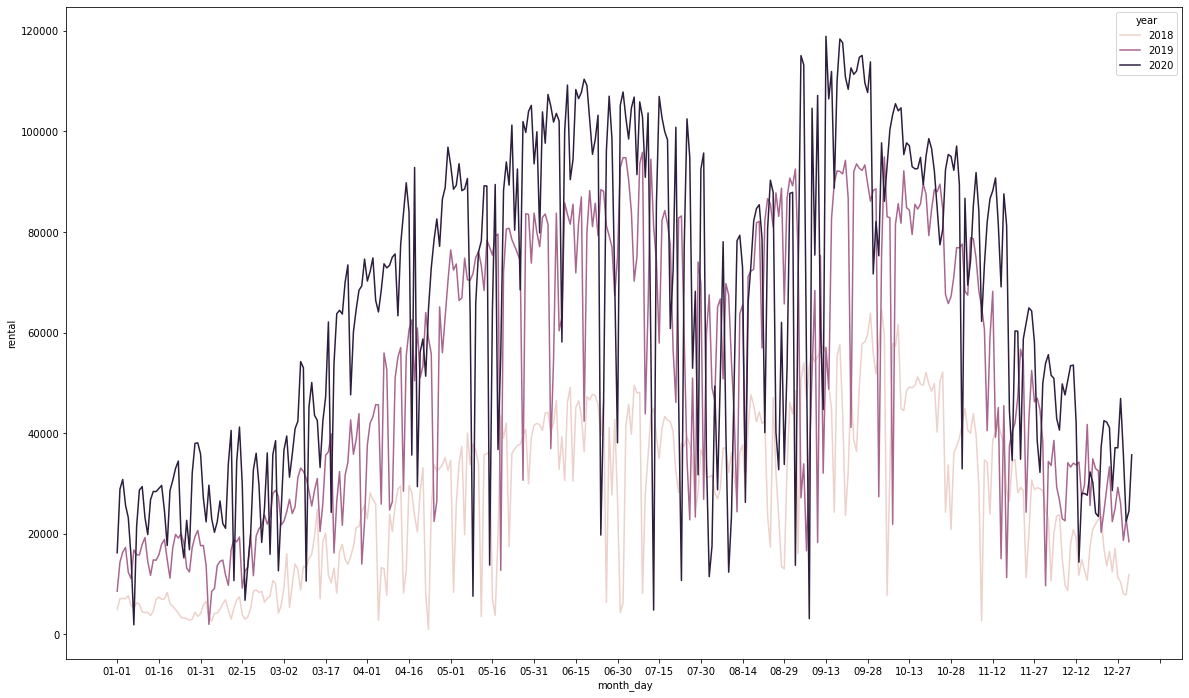

In [288]:
plt.figure(figsize = (20, 12))
sns.lineplot(x = 'month_day', y = 'rental', data = train, hue = 'year')
plt.xticks(list(range(0, 16*2*12, 15)))
plt.show()

In [312]:
# date 삭제
train = train.drop(columns=['date', 'month_day'])
test = test.drop(columns=['date', 'month_day'])
train.shape

(1095, 15)

### eda

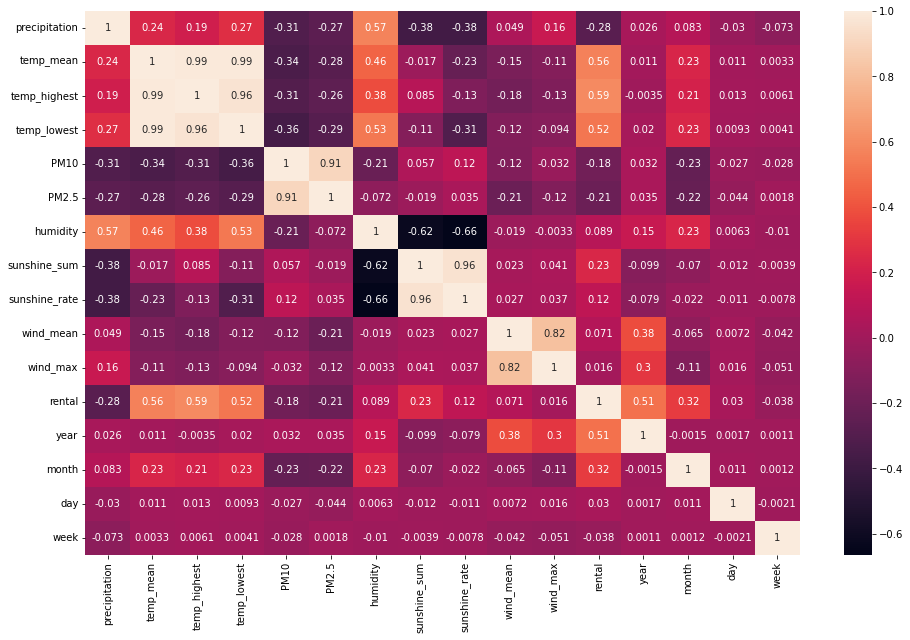

In [14]:
plt.figure(figsize = (16, 10))
sns.heatmap(train.corr(), annot = True)
plt.show()

corr 의미없음(pm10, humidity, sunshine_rate, wind_mean, wind_max, day, week)


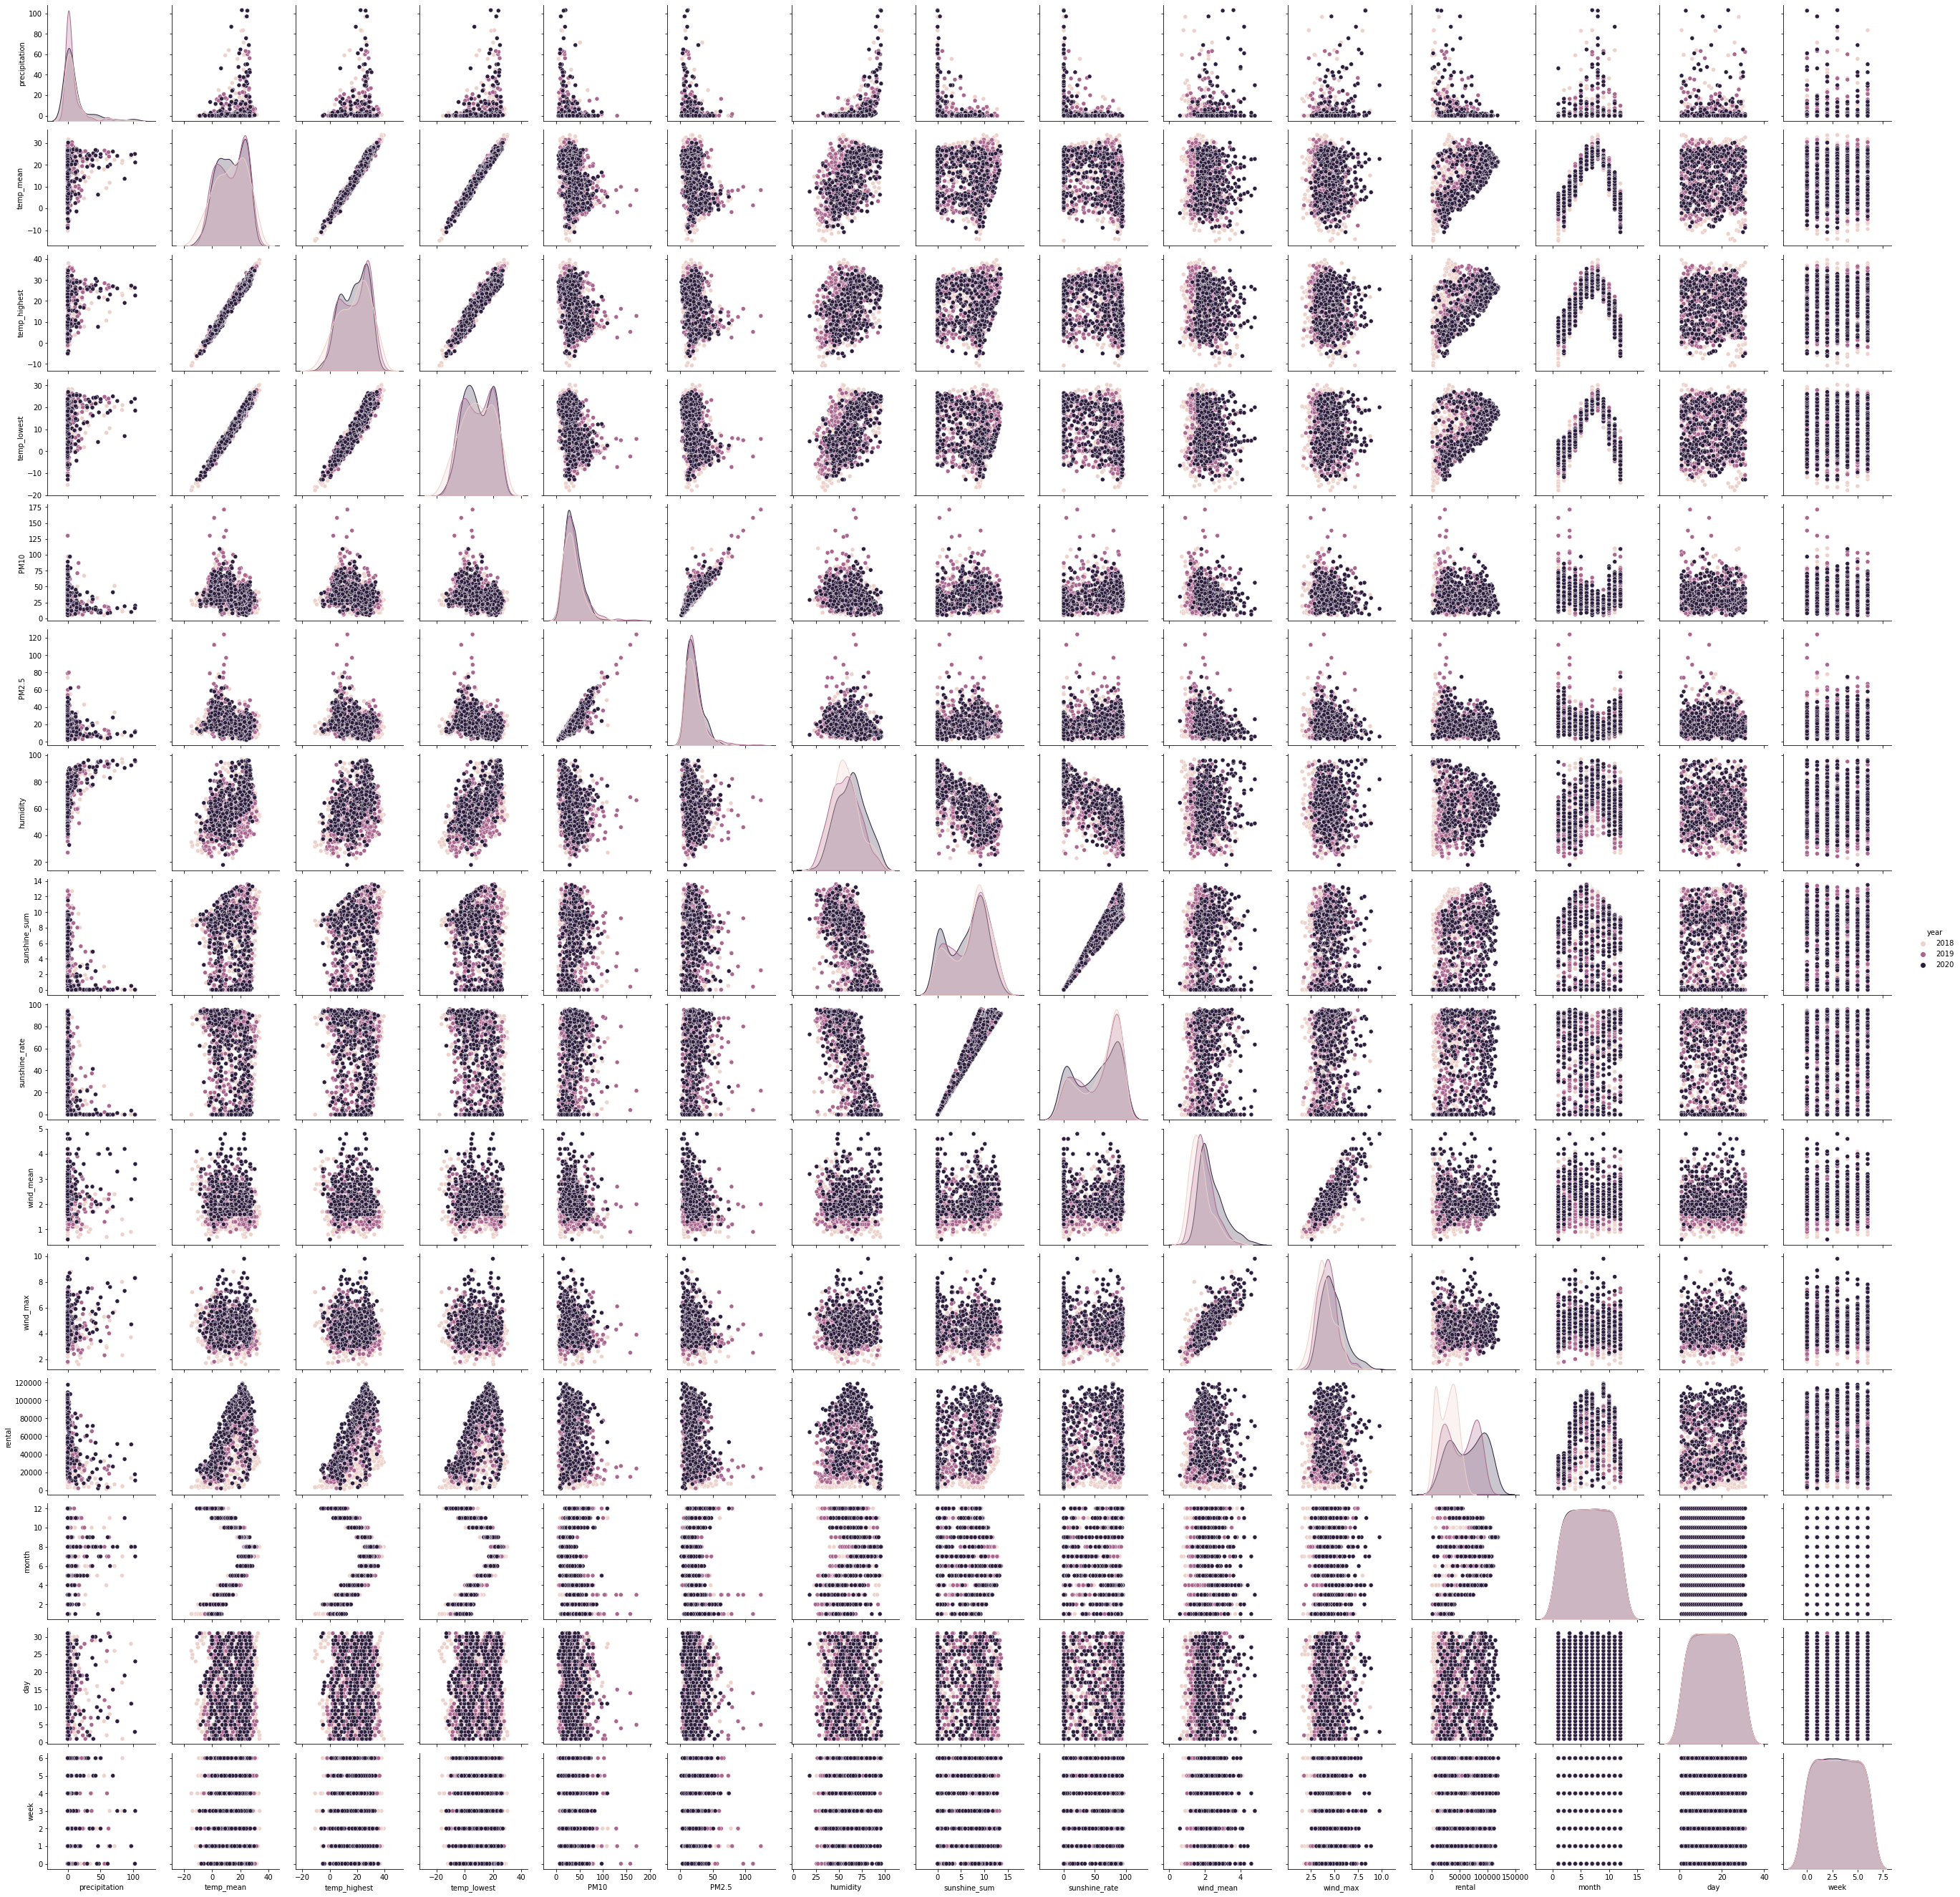

In [15]:
sns.pairplot(train, hue = 'year')
plt.show()

비올때 그리고 미세먼지, 초미세먼지가 많을때 따릉이 사용량이 줄어듦

### 결측치 처리


In [313]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 

train_copy = train.copy()
test_copy = test.copy()

def null(df): 
    # 결측치(0)
    df['precipitation'] = df['precipitation'].fillna(0)
    df['sunshine_sum'] = df['sunshine_sum'].fillna(0)
    # 결측치(iterative)
    df = IterativeImputer(random_state=2021).fit_transform(df)
    df = pd.DataFrame(df)
    if df.shape[1] == train_copy.shape[1]:
        df.columns = train_copy.columns
    else:
        df.columns = test_copy.columns 
    return df

train = null(train)
test = null(test)
train.shape

(1095, 15)

### 이상치 처리

In [333]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, max_samples='auto', n_jobs=-1, max_features=2, contamination=0.01)
model.fit(train.to_numpy())

#score = model.decision_function(train.to_numpy())
#train['scores']= score
anomaly = model.predict(train.to_numpy())
train['anomaly']= anomaly

train = train[train['anomaly']==1]
train = train.drop(columns='anomaly')
train.head()

precipitation  temp_mean  temp_highest  temp_lowest  PM10  PM2.5  \
0            0.0       -1.3           3.8         -5.1  34.0   17.0   
1            0.0       -1.8           1.8         -4.3  36.0   22.0   
2            0.0       -4.7          -0.4         -7.1  31.0   19.0   
3            0.0       -4.7          -0.7         -8.7  39.0   24.0   
4            0.0       -3.0           1.6         -5.6  51.0   35.0   

   sunshine_sum  sunshine_rate  wind_mean  wind_max  ...  \
0           8.3           86.5        1.4       3.8  ...   
1           7.9           82.3        1.8       4.9  ...   
2           8.6           88.7        2.2       3.5  ...   
3           6.2           63.9        1.4       3.5  ...   
4           8.2           84.5        1.7       3.6  ...   

   discomfort*temp_diff  discomfort*cold  discomfort*hard  \
0                 356.0       -53.684211         13148.00   
1                 231.8       -33.346939         15324.26   
2                 234.5       -71.000000         10865.75   
3                 272.0       -84.514286          7604.10   
4                 259.2       -56.000000         10951.20   

   temp_diff*temp_diff  temp_diff*cold  temp_diff*hard  cold*cold  cold*hard  \
0                79.21      -11.944737        2925.430   1.801247    -441.15   
1                37.21       -5.353061        2459.947   0.770096    -353.89   
2                44.89      -13.591429        2080.015   4.115102    -629.77   
3                64.00      -19.885714        1789.200   6.178776    -555.93   
4                51.84      -11.200000        2190.240   2.419753    -473.20   

     hard*hard  rental  
0  108043.6900  4950.0  
1  162626.6929  7136.0  
2   96379.2025  7156.0  
3   50019.3225  7102.0  
4   92537.6400  7705.0  

[5 rows x 253 columns]

### 변수 생성

#### 미세먼지 주의보 발령 기준

In [92]:
# 미세먼지 주의보 발령 기준
train[train['PM10']>=150] # 2개
train[train['PM2.5']>=75] # 8개

date  precipitation  temp_mean  temp_highest  temp_lowest   PM10  \
16    2018-01-17            NaN        4.5           8.7          2.4   99.0   
378   2019-01-14            NaN        1.4           5.3         -2.4  158.0   
379   2019-01-15            0.0       -1.7           2.6         -7.2  130.0   
427   2019-03-04            NaN        9.9          16.3          5.0  138.0   
428   2019-03-05            NaN        8.4          12.9          5.6  171.0   
429   2019-03-06            NaN        8.4          12.4          5.7  128.0   
707   2019-12-10            1.7        8.1          10.8          6.0   97.0   
1074  2020-12-11            NaN        5.3           9.4          2.6  109.0   

      PM2.5  humidity  sunshine_sum  sunshine_rate  wind_mean  wind_max  \
16     78.0      64.1           4.8           48.5        1.2       3.7   
378   112.0      68.6           0.4            4.1        0.9       2.5   
379    79.0      58.8           4.7           47.5        2.7       6.1   
427    97.0      46.1           9.2           80.0        1.9       4.7   
428   124.0      66.3           2.5           21.7        2.0       3.9   
429    89.0      55.0           3.0           26.1        2.0       4.3   
707    80.0      82.3           2.0           20.6        1.2       3.5   
1074   75.0      77.1           2.4           25.0        1.8       4.5   

      rental  
16      6990  
378    14818  
379    14761  
427    26887  
428    24042  
429    25379  
707    33275  
1074   53536

In [314]:
# 미세먼지 기준
def mise(x):
    if 0<=x<=30: # 좋음
        return 0
    elif 30<x<=80: # 보통
        return 1
    elif 80<x<=150: # 나쁨
        return 2
    else : # 매우나쁨
        return 3
    
train['mise'] = train['PM10'].apply(mise)
test['mise'] = test['PM10'].apply(mise)

In [315]:
# 초미세먼지 기준
def chomise(x):
    if 0<=x<=15: # 좋음
        return 0
    elif 15<x<=35: # 보통
        return 1
    elif 36<x<=75: # 나쁨
        return 2
    else : # 매우나쁨
        return 3
    
train['chomise'] = train['PM2.5'].apply(chomise)
test['chomise'] = test['PM2.5'].apply(chomise)
train.shape

(1095, 17)

#### 대기질측정정보

In [50]:
pm = pd.read_csv('./input/dankook/대기질측정정보(2018년).csv', encoding='cp949')
pm

시군코드  시군명      측정소명  설치년도   측정망명             측정일시각  아황산가스농도값  \
0       41820  가평군        가평  2010   도시대기  2018-12-31 24:00     0.004   
1       41280  고양시  백마로(마두역)  2004  도로변대기  2018-12-31 24:00     0.005   
2       41280  고양시       식사동  2002   도시대기  2018-12-31 24:00     0.003   
3       41280  고양시       신원동  2016   도시대기  2018-12-31 24:00     0.010   
4       41280  고양시       행신동  1998   도시대기  2018-12-31 24:00     0.005   
...       ...  ...       ...   ...    ...               ...       ...   
662315  41190  부천시      소사본동  1987   도시대기  2018-01-01 01:00       NaN   
662316  41110  수원시       신풍동  1986   도시대기  2018-01-01 01:00       NaN   
662317  41500  이천시       설성면  2000   교외대기  2018-01-01 01:00     0.001   
662318  41480  파주시        파주  2017   교외대기  2018-01-01 01:00     0.003   
662319  41650  포천시       관인면  2001   교외대기  2018-01-01 01:00     0.002   

        일산화탄소농도값  오존농도값  이산화질소농도값  미세먼지PM10농도값  미세먼지PM2.5농도값  
0            0.8  0.008     0.025         35.0          26.0  
1            1.1  0.003     0.055         78.0          39.0  
2            0.5  0.003     0.069        100.0          18.0  
3            0.8  0.003     0.038         55.0          33.0  
4            0.7  0.002     0.042         46.0          33.0  
...          ...    ...       ...          ...           ...  
662315       NaN    NaN       NaN          NaN           NaN  
662316       NaN    NaN       NaN          NaN           NaN  
662317       0.3  0.022     0.011         43.0           NaN  
662318       0.4  0.027     0.006         47.0          21.0  
662319       0.5  0.023     0.007         33.0          16.0  

[662320 rows x 12 columns]

In [58]:

pm = pd.read_csv('./input/dankook/대기질측정정보(2018년).csv', encoding='cp949')
pm[pm['시군명']=='용인시']
#pm['시군명'].unique()

시군코드  시군명       측정소명  설치년도   측정망명             측정일시각  아황산가스농도값  \
61      41460  용인시         기흥  2006   도시대기  2018-12-31 24:00     0.003   
62      41460  용인시       김량장동  1999   도시대기  2018-12-31 24:00     0.003   
63      41460  용인시         수지  2005   도시대기  2018-12-31 24:00     0.003   
64      41460  용인시  중부대로(구갈동)  2011  도로변대기  2018-12-31 24:00     0.003   
144     41460  용인시         기흥  2006   도시대기  2018-12-31 23:00     0.003   
...       ...  ...        ...   ...    ...               ...       ...   
662206  41460  용인시  중부대로(구갈동)  2011  도로변대기  2018-01-01 05:00     0.003   
662284  41460  용인시         기흥  2006   도시대기  2018-01-01 04:00     0.005   
662285  41460  용인시       김량장동  1999   도시대기  2018-01-01 04:00     0.005   
662286  41460  용인시         수지  2005   도시대기  2018-01-01 04:00     0.003   
662287  41460  용인시  중부대로(구갈동)  2011  도로변대기  2018-01-01 04:00     0.003   

        일산화탄소농도값  오존농도값  이산화질소농도값  미세먼지PM10농도값  미세먼지PM2.5농도값  
61           0.6  0.003     0.048         35.0          22.0  
62           0.7  0.003     0.054         45.0          33.0  
63           0.6  0.002     0.047         32.0          25.0  
64           0.7    NaN     0.050         38.0          23.0  
144          0.6  0.003     0.048         26.0          19.0  
...          ...    ...       ...          ...           ...  
662206       0.6    NaN     0.032         37.0          19.0  
662284       0.7  0.005     0.039         33.0           6.0  
662285       0.6  0.001     0.030         44.0           NaN  
662286       0.6  0.019     0.009         34.0          14.0  
662287       0.5    NaN     0.031         34.0          20.0  

[31908 rows x 12 columns]

In [87]:
pm = pd.read_csv('./input/dankook/대기질측정정보(2018년).csv', encoding='cp949')
#pm.info()
pm['측정일시각'] = pm['측정일시각'].str[:10]
pm['측정일시각'] = pd.to_datetime(pm['측정일시각'])
#pm = pm[pm['측정소명']=='수지'][['측정소명', '측정일시각', '미세먼지PM10농도값', '미세먼지PM2.5농도값']]
pm = pm[pm['시군명']=='용인시'][['측정소명', '측정일시각', '미세먼지PM10농도값', '미세먼지PM2.5농도값']]
pm= pm.groupby('측정일시각')['미세먼지PM10농도값', '미세먼지PM2.5농도값'].mean()
pm.head(10)

미세먼지PM10농도값  미세먼지PM2.5농도값
측정일시각                                
2018-01-01    49.488095     24.161290
2018-01-02    50.108696     25.506329
2018-01-03    38.826087     20.728261
2018-01-04    53.850575     28.727273
2018-01-05    67.583333     42.074468
2018-01-06    60.479167     40.302083
2018-01-07    63.520833     45.946809
2018-01-08    63.322581     47.392857
2018-01-09    44.573034     21.166667
2018-01-10    36.223404     14.989362

In [105]:
pm = pd.read_csv('./input/dankook/대기질측정정보(2018년).csv', encoding='cp949')
#pm.info()
pm['측정일시각'] = pm['측정일시각'].str[:10]
pm['측정일시각'] = pd.to_datetime(pm['측정일시각'])
#pm = pm[pm['측정소명']=='수지'][['측정소명', '측정일시각', '미세먼지PM10농도값', '미세먼지PM2.5농도값']]
pm = pm[pm['시군명']=='용인시'][['측정소명', '측정일시각', '미세먼지PM10농도값', '미세먼지PM2.5농도값']]
pm= pm.groupby('측정일시각')['미세먼지PM10농도값', '미세먼지PM2.5농도값'].mean()
len(pm)

363

In [55]:
pm = pd.read_csv('./input/dankook/대기질측정정보(2018년).csv', encoding='cp949')
pm['수지']

2018-08-11 09:00    2213
2018-03-29 10:00    1530
2018-02-03 18:00    1433
2018-04-23 14:00     561
2018-10-31 11:00     501
                    ... 
2018-01-28 17:00       1
2018-01-31 08:00       1
2018-11-12 10:00       1
2018-01-28 20:00       1
2018-01-15 24:00       1
Name: 측정일시각, Length: 8025, dtype: int64

#### 미세먼지, 초미세먼지의 새로운 데이터
데이터URL : https://www.airkorea.or.kr/web/last_amb_hour_data?pMENU_NO=123

In [40]:
'''
%%time # Wall time: 38min 49s


# 2018년 미세먼지 데이터
for j in range(1, 5):
    globals()['df_2018_{0}'.format(j)] = pd.read_excel('./input/dankook/2018년 {0}분기.xlsx'.format(j))

# 2019, 2020년 미세먼지 데이터    
df_2019_3 = pd.read_excel('./input/dankook/2019년 3월.xlsx')
df_2019_7 = pd.read_excel('./input/dankook/2019년 7월.xlsx') # pm2.5
df_2019_8 = pd.read_excel('./input/dankook/2019년 8월.xlsx') # pm2.5
df_2019_9 = pd.read_excel('./input/dankook/2019년 9월.xlsx')
df_2020_2 = pd.read_excel('./input/dankook/2020년 2월.xlsx')


df_mise = pd.concat([df_2018_1, df_2018_2, df_2018_3, df_2018_4, df_2019_3, df_2019_7, df_2019_8, df_2019_9, df_2020_2])
df_mise.head()
df_mise.to_csv('df_mise.csv')'''

Wall time: 38min 49s


In [78]:
%%time

# 수지구 추출 + 측정일시 타입변환 + 변수명재설정 + groupby
df_mise = pd.read_csv('df_mise.csv')

df_mise = df_mise[df_mise['측정소명'] == '수지']
df_mise['측정일시'] = df_mise['측정일시'].astype(str).str[:8]
df_mise['측정일시'] = pd.to_datetime(df_mise['측정일시'])
df_mise.rename(columns = {'측정일시':'date', 'PM10':'new_PM10', 'PM25':'new_PM25'}, inplace=True)
df_mise = df_mise.groupby('date')['new_PM10', 'new_PM25'].mean()
df_mise = df_mise.reset_index()
# 두 데이터 프레임 합치기 + null값 채우기
train_mise = pd.merge(train, df_mise, how='outer',on='date')
train_mise['pm10_New'] = np.where(pd.notnull(train_mise['PM10']) == True, train_mise['PM10'], train_mise['new_PM10'])
train_mise['pm25_New'] = np.where(pd.notnull(train_mise['PM2.5']) == True, train_mise['PM2.5'], train_mise['new_PM25'])

# 필요없는 변수, 행 제거
train_mise = train_mise.drop(columns = ['date', 'PM10', 'PM2.5', 'new_PM10', 'new_PM25'])
train_mise = train_mise.dropna()
train_mise

C:\Users\HOME\anaconda3\lib\site-packages\IPython\core\magics\execution.py:1324: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 10.3 s


<timed exec>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


precipitation  temp_mean  temp_highest  temp_lowest  humidity  \
0               0.0       -1.3           3.8         -5.1      39.1   
1               0.0       -1.8           1.8         -4.3      42.0   
2               0.0       -4.7          -0.4         -7.1      42.3   
3               0.0       -4.7          -0.7         -8.7      43.0   
4               0.0       -3.0           1.6         -5.6      48.4   
...             ...        ...           ...          ...       ...   
1090            0.0        5.8          10.0          1.4      62.9   
1091            1.3        6.7          11.4          4.2      72.1   
1092            0.2        0.1           4.3         -6.2      70.8   
1093            0.0      -10.9          -6.2        -12.9      55.5   
1094            0.0       -8.9          -5.0        -12.9      53.9   

      sunshine_sum  sunshine_rate  wind_mean  wind_max   rental    year  \
0              8.3           86.5        1.4       3.8   4950.0  2018.0   
1              7.9           82.3        1.8       4.9   7136.0  2018.0   
2              8.6           88.7        2.2       3.5   7156.0  2018.0   
3              6.2           63.9        1.4       3.5   7102.0  2018.0   
4              8.2           84.5        1.7       3.6   7705.0  2018.0   
...            ...            ...        ...       ...      ...     ...   
1090           5.9           61.5        1.8       2.8  37103.0  2020.0   
1091           8.0           83.3        1.4       3.1  46912.0  2020.0   
1092           0.0            0.0        2.9       6.1  35747.0  2020.0   
1093           8.3           86.5        4.1       6.2  22488.0  2020.0   
1094           6.0           62.5        2.4       4.2  24535.0  2020.0   

      month   day  week  pm10_New  pm25_New  
0       1.0   1.0   0.0      34.0      17.0  
1       1.0   2.0   1.0      36.0      22.0  
2       1.0   3.0   2.0      31.0      19.0  
3       1.0   4.0   3.0      39.0      24.0  
4       1.0   5.0   4.0      51.0      35.0  
...     ...   ...   ...       ...       ...  
1090   12.0  27.0   6.0      70.0      42.0  
1091   12.0  28.0   0.0      66.0      44.0  
1092   12.0  29.0   1.0      69.0      46.0  
1093   12.0  30.0   2.0      39.0      15.0  
1094   12.0  31.0   3.0      28.0      12.0  

[1095 rows x 16 columns]

#### 사용량이 많은 달


<BarContainer object of 1084 artists>

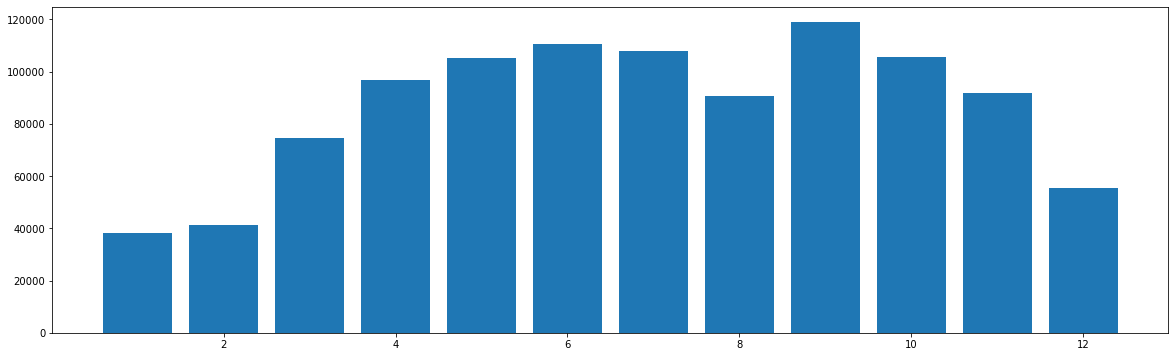

In [71]:
plt.figure(figsize = (20,6))
plt.bar(train['month'], train['rental'])

In [316]:
def month(x):
    if 3 < x < 12: # 사용량이 많은 달 
        return 1
    else: # 사용량이 적은 달 
        return 0
        
train['month_bin'] = train['month'].apply(month)
test['month_bin'] = test['month'].apply(month)
train.shape

(1095, 18)

#### 주말과 평일 

In [317]:
def weekend(x):
    if x >= 5:
        return 1
    else:
        return 0

train['weekend'] = train['week'].apply(weekend)
test['weekend'] = test['week'].apply(weekend)
train.shape

(1095, 19)

In [148]:
train['rental'].groupby(train['weekend']).agg('mean')

weekend
0    49304.473214
1    45810.726688
Name: rental, dtype: float64

#### 불쾌지수

In [318]:
def get_discomfort(humid, min_x, max_x):
    # 전체적인 탑승의 경향성을 반영하기 위해 출퇴근 시간의 사용량이 많음에도 불구하고, 평균온도로 고려합니다.
    temp = (min_x + max_x)/2
    humid = humid / 100
    
    discomfort = 1.8 * temp - 0.558 * (1 - humid) * (1.8*temp - 26) + 32
    return discomfort

train['discomfort'] = [0] * len(train)
for i in range(len(train)):
    train['discomfort'][i] = get_discomfort(train['humidity'][i], train['temp_lowest'][i], train['temp_highest'][i])
    
test['discomfort'] = [0] * len(test)
for i in range(len(test)):
    test['discomfort'][i] = get_discomfort(test['humidity'][i], test['temp_lowest'][i], test['temp_highest'][i])

train.shape

C:\Users\HOME\AppData\Local\Temp/ipykernel_12532/2782052660.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['discomfort'][i] = get_discomfort(train['humidity'][i], train['temp_lowest'][i], train['temp_highest'][i])
C:\Users\HOME\AppData\Local\Temp/ipykernel_12532/2782052660.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['discomfort'][i] = get_discomfort(test['humidity'][i], test['temp_lowest'][i], test['temp_highest'][i])


(1095, 20)

In [319]:
train = train.drop('humidity', axis = 1)
test = test.drop('humidity', axis = 1)

#### 일교차

In [320]:
train['temp_diff'] = train['temp_highest'] - train['temp_lowest'] 
test['temp_diff'] = test['temp_highest'] - test['temp_lowest']

In [321]:
train['cold'] = train['temp_lowest'] / train['wind_max']
test['cold'] = test['temp_lowest'] / test['wind_max']

In [322]:
train['hard'] = train['sunshine_rate'] * train['wind_max']
test['hard'] = test['sunshine_rate'] * test['wind_max']

In [323]:
def computer(df):
    computer = df.copy()
    col = df.columns

    for i in range(len(col)):
        for j in range(i, len(col)):
            df[f'{col[i]}*{col[j]}'] = computer[col[i]] * computer[col[j]]
    return df

train_rental = train.rental
train = train.drop(columns = 'rental')
train = computer(train)
train = pd.concat([train, train_rental], axis=1)

test = computer(test)
train.shape

C:\Users\HOME\AppData\Local\Temp/ipykernel_12532/4039211896.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col[i]}*{col[j]}'] = computer[col[i]] * computer[col[j]]


(1095, 253)

In [324]:
train.corr()['rental']

precipitation    -0.210272
temp_mean         0.563741
temp_highest      0.591219
temp_lowest       0.524770
PM10             -0.175224
                    ...   
temp_diff*hard    0.183017
cold*cold         0.198117
cold*hard         0.564564
hard*hard         0.067009
rental            1.000000
Name: rental, Length: 253, dtype: float64

#### 변수 중요도(xgb)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

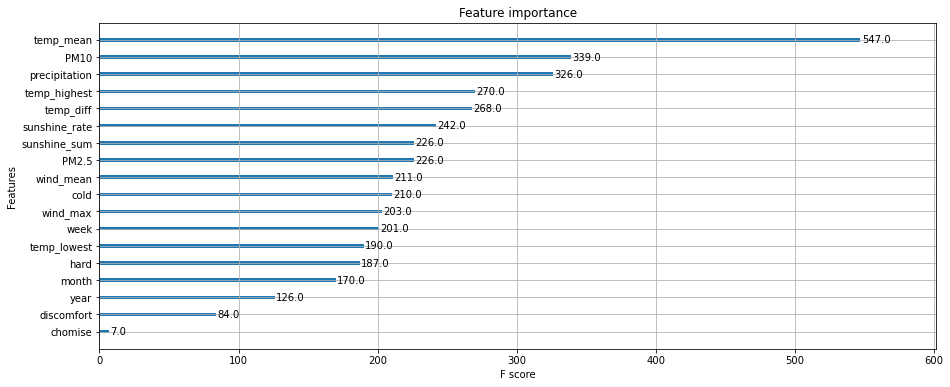

In [218]:
from xgboost import XGBRegressor
from xgboost import plot_importance


X_train = train.drop(['rental'],axis=1)
y_train = train['rental']
X_test = test

xgb2 = XGBRegressor(random_state=1217)
xgb2.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(15,6)) 
plot_importance(xgb2, ax=ax)

#### polynomial

In [147]:
train2 = train1[train1.columns.difference(['rental'])]
#train2 = train2.columns.tolist()
train2 = np.column_stack((train2['temp_mean']**5, train2['humidity']**4, train2))
train2
pd.DataFrame(train2)

0             1     2     3     4     5     6    7    8   \
0         -3.71293  2.337260e+06  34.0  17.0   1.0  39.1   1.0  0.0  0.0   
1        -18.89568  3.111696e+06  36.0  22.0   2.0  42.0   1.0  0.0  0.0   
2      -2293.45007  3.201559e+06  31.0  19.0   3.0  42.3   1.0  0.0  0.0   
3      -2293.45007  3.418801e+06  39.0  24.0   4.0  43.0   1.0  0.0  0.0   
4       -243.00000  5.487587e+06  51.0  35.0   5.0  48.4   1.0  0.0  0.0   
...            ...           ...   ...   ...   ...   ...   ...  ...  ...   
1090    6563.56768  1.565318e+07  70.0  42.0  27.0  62.9  12.0  0.0  0.0   
1091   13501.25107  2.702347e+07  66.0  44.0  28.0  72.1  12.0  0.0  1.3   
1092       0.00001  2.512656e+07  69.0  46.0  29.0  70.8  12.0  0.0  0.2   
1093 -153862.39549  9.487940e+06  39.0  15.0  30.0  55.5  12.0  0.0  0.0   
1094  -55840.59449  8.440245e+06  28.0  12.0  31.0  53.9  12.0  0.0  0.0   

        9    10    11    12    13   14   15   16      17  
0     86.5  8.3   3.8  -5.1  -1.3  0.0  3.8  1.4  2018.0  
1     82.3  7.9   1.8  -4.3  -1.8  1.0  4.9  1.8  2018.0  
2     88.7  8.6  -0.4  -7.1  -4.7  2.0  3.5  2.2  2018.0  
3     63.9  6.2  -0.7  -8.7  -4.7  3.0  3.5  1.4  2018.0  
4     84.5  8.2   1.6  -5.6  -3.0  4.0  3.6  1.7  2018.0  
...    ...  ...   ...   ...   ...  ...  ...  ...     ...  
1090  61.5  5.9  10.0   1.4   5.8  6.0  2.8  1.8  2020.0  
1091  83.3  8.0  11.4   4.2   6.7  0.0  3.1  1.4  2020.0  
1092   0.0  0.0   4.3  -6.2   0.1  1.0  6.1  2.9  2020.0  
1093  86.5  8.3  -6.2 -12.9 -10.9  2.0  6.2  4.1  2020.0  
1094  62.5  6.0  -5.0 -12.9  -8.9  3.0  4.2  2.4  2020.0  

[1095 rows x 18 columns]

In [ ]:
#### 

#### Pycaret

In [335]:
!pip install pycaret
!pip install Jinja2
!pip install markupsafe==2.0.

^C
^C


In [ ]:
import pycaret
from pycaret.classification import *
from pycaret.regression import *

reg = setup(train1, target = 'rental', train_size =0.8)
best = compare_models(sort = 'MAE')

### rf

In [132]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_features=8, min_samples_leaf=1, n_estimators=590)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [ ]:
# 11-2. 예시1
from sklearn.model_selection import GridSearchCV

param = [{'kernel' : ['linear', 'rbf'],
          'gamma' : [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}]

model = RandomForestRegressor()
grid_search = GridSearchCV(model, param, cv=5, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train, y_train)

grid_search.best_params_

neg = grid_search.best_score_ # Best score: -0.737
rmse = np.sqrt(-neg)

for param_name in sorted(param.keys()):
    print("\t%s: %r" % (param_name, model.best_estimator_.get_params()[param_name]))

In [130]:
%%time
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=1217)
params = {'n_estimators': stats.randint(200, 1000),
          'max_features': stats.randint(4, 12),
          'min_samples_leaf': stats.randint(1, 5)}

# RandomizedSearchCV를 이용해 최적의 하이퍼파라미터 탐색
rand_cv = RandomizedSearchCV(rf, param_distributions = params, n_iter=10, 
                             cv = 3, random_state = 1217, n_jobs=-1)
rand_cv.fit(X_train, y_train)

# 최적의 하이퍼파라미터 값과 성능 출력
print('최적 하이퍼파라미터: ', rand_cv.best_params_)
print('최적 하이퍼파라미터의 성능(RMSE): {:.4f}'.format(np.sqrt(rand_cv.best_score_)))

최적 하이퍼파라미터:  {'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 590}
최적 하이퍼파라미터의 성능(RMSE): 0.9561
Wall time: 45.2 s


In [134]:
NMAE(y_val, pred)

0.21381712106313697

### xgb

#### 기본 xgb

In [325]:
%%time
import numpy as np

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

from xgboost import XGBRegressor

X_train = train.drop(['rental'], axis=1)
y_train = train["rental"]

X_test = test
y_test = y_test

xgb = XGBRegressor(max_depth = 4, n_estimators = 100)
xgb.fit(X_train, y_train)
pred_xgb1 = 1.4*xgb.predict(X_test) # https://mobile.newsis.com/view.html?ar_id=NISX20220627_0001921325#_enliple
NMAE(y_test['대여건수'].values, pred_xgb1)

Wall time: 3.18 s


0.24746734404041804

In [ ]:
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = pred_xgb1
submission.to_csv('./output/dankook/xgb.csv', index=False)
submission

In [213]:
reg_2018 = sum(train.loc[train['year'] == 2018, 'rental'].values)
reg_2019 = sum(train.loc[train['year'] == 2019, 'rental'].values)
reg_2020 = sum(train.loc[train['year'] == 2020, 'rental'].values)
reg_2021 = sum(y_test['대여건수'].values)

print(reg_2019/reg_2018)
print(reg_2020/reg_2019)
print(reg_2021/reg_2020)

1.8836727252111978
1.2429259327402773
1.3522322697892684


#### xgb + 랜덤서치

In [154]:
%%time
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBRegressor(random_state=1217)
params = {
    'n_estimators': [200, 500, 1000, 2000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [6, 7, 8], 
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'subsample': [0.8, 0.9, 1.0],
}

# RandomizedSearchCV를 이용해 최적의 하이퍼파라미터 탐색
rand_cv = RandomizedSearchCV(xgb_model, param_distributions = params, n_iter=10, cv = 3, random_state = 1217, n_jobs=-1)
rand_cv.fit(X_train, y_train)

# 최적의 하이퍼파라미터 값과 성능 출력
print('최적 하이퍼파라미터: ', rand_cv.best_params_)
print('최적 하이퍼파라미터의 성능(RMSE): {:.4f}'.format(np.sqrt(rand_cv.best_score_)))

최적 하이퍼파라미터:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
최적 하이퍼파라미터의 성능(RMSE): 0.5480
Wall time: 26.3 s


In [155]:
%%time

xgb = XGBRegressor(subsample=0.8, n_estimators=200, max_depth=8, learning_rate=0.01, colsample_bytree=1.0, random_state=1217)
xgb.fit(X_train, y_train)
pred_xgb_upgrade = xgb.predict(X_test)
# NMAE(y_val, pred2)
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = pred_xgb_upgrade
submission.to_csv('./output/dankook/xgb_upgrade.csv', index=False)
submission

Wall time: 603 ms


date        rental
0    2021-01-01  19233.193359
1    2021-01-02  18876.439453
2    2021-01-03  17938.017578
3    2021-01-04  21513.869141
4    2021-01-05  18742.099609
5    2021-01-06  14586.430664
6    2021-01-07  16729.654297
7    2021-01-08  17564.785156
8    2021-01-09  18691.929688
9    2021-01-10  18024.939453
10   2021-01-11  17616.166016
11   2021-01-12  12002.986328
12   2021-01-13  23485.083984
13   2021-01-14  23926.746094
14   2021-01-15  23864.285156
15   2021-01-16  18367.562500
16   2021-01-17  17402.667969
17   2021-01-18  14512.997070
18   2021-01-19  18817.353516
19   2021-01-20  23516.410156
20   2021-01-21  12786.002930
21   2021-01-22  15311.700195
22   2021-01-23  21673.865234
23   2021-01-24  32157.640625
24   2021-01-25  34612.722656
25   2021-01-26  12107.183594
26   2021-01-27  22045.771484
27   2021-01-28  13521.898438
28   2021-01-29  15048.654297
29   2021-01-30  15188.441406
30   2021-01-31  18704.937500
31   2021-02-01  21088.755859
32   2021-02-02  17765.160156
33   2021-02-03  14997.275391
34   2021-02-04  16029.930664
35   2021-02-05  21355.105469
36   2021-02-06  22098.214844
37   2021-02-07  19519.208984
38   2021-02-08  21865.494141
39   2021-02-09  23727.132812
40   2021-02-10  20293.968750
41   2021-02-11  26651.914062
42   2021-02-12  32970.101562
43   2021-02-13  32707.392578
44   2021-02-14  28937.195312
45   2021-02-15  16428.003906
46   2021-02-16  14027.371094
47   2021-02-17  17542.707031
48   2021-02-18  18233.353516
49   2021-02-19  25188.091797
50   2021-02-20  42493.593750
51   2021-02-21  45081.949219
52   2021-02-22  29455.199219
53   2021-02-23  23571.857422
54   2021-02-24  28651.990234
55   2021-02-25  20939.513672
56   2021-02-26  47029.531250
57   2021-02-27  54913.585938
58   2021-02-28  19884.371094
59   2021-03-01  12200.467773
60   2021-03-02  29506.656250
61   2021-03-03  36502.218750
62   2021-03-04  36897.078125
63   2021-03-05  54649.269531
64   2021-03-06  33355.921875
65   2021-03-07  31984.337891
66   2021-03-08  43324.519531
67   2021-03-09  36199.324219
68   2021-03-10  38069.523438
69   2021-03-11  37338.058594
70   2021-03-12  36059.089844
71   2021-03-13  39988.117188
72   2021-03-14  35682.078125
73   2021-03-15  31793.464844
74   2021-03-16  38938.050781
75   2021-03-17  50899.378906
76   2021-03-18  53308.121094
77   2021-03-19  64819.906250
78   2021-03-20  27215.632812
79   2021-03-21  26318.925781
80   2021-03-22  37529.320312
81   2021-03-23  53053.226562
82   2021-03-24  53006.816406
83   2021-03-25  61944.679688
84   2021-03-26  46894.925781
85   2021-03-27  18533.023438
86   2021-03-28  14003.448242
87   2021-03-29  36721.695312
88   2021-03-30  57406.570312
89   2021-03-31  65922.164062
90   2021-04-01  70292.335938
91   2021-04-02  64495.367188
92   2021-04-03  16388.484375
93   2021-04-04  54348.855469
94   2021-04-05  66830.117188
95   2021-04-06  69836.882812
96   2021-04-07  69816.164062
97   2021-04-08  67807.570312
98   2021-04-09  69821.796875
99   2021-04-10  67290.703125
100  2021-04-11  68790.023438
101  2021-04-12  20655.144531
102  2021-04-13  35916.613281
103  2021-04-14  56661.769531
104  2021-04-15  65392.398438
105  2021-04-16  49226.710938
106  2021-04-17  51917.820312
107  2021-04-18  60852.789062
108  2021-04-19  67884.898438
109  2021-04-20  70413.734375
110  2021-04-21  71219.132812
111  2021-04-22  62528.679688
112  2021-04-23  63774.460938
113  2021-04-24  65483.378906
114  2021-04-25  72275.906250
115  2021-04-26  71236.562500
116  2021-04-27  51284.386719
117  2021-04-28  48202.550781
118  2021-04-29  50103.468750
119  2021-04-30  29288.875000
120  2021-05-01  31752.882812
121  2021-05-02  66809.726562
122  2021-05-03  79886.625000
123  2021-05-04  22738.046875
124  2021-05-05  76882.234375
125  2021-05-06  80631.242188
126  2021-05-07  43682.988281
127  2021-05-08  76549.875000
128  2021-05-09  79280.820312
129  2021-05-10  65219.871094
130  2021-05-11  82045.945312
131  2021-05-12  81920.406250
132  2021-05-13  8361

In [174]:
%%time

xgb = XGBRegressor(subsample=0.8, n_estimators=200, max_depth=8, learning_rate=0.01, colsample_bytree=1.0, random_state=1217)
xgb.fit(X_train, y_train)
pred_xgb_upgrade1 = xgb.predict(X_val)
NMAE(y_val, pred_xgb_upgrade1)

Wall time: 338 ms


0.40867710158668014

In [175]:
NMAE(y_val, (pred_xgb1+pred_xgb_upgrade1)/2)

0.36060901374490717

In [157]:
# https://dacon.io/competitions/official/235736/codeshare/2877?page=1&dtype=recent
xgb_params = pd.read_csv('./input/dankook/hyperparameter_xgb.csv')
xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[47,1], min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], seed=0)

xgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train)],
        early_stopping_rounds=300,
       verbose=False)

pred_xgb_hyper = xgb_reg.predict(X_test)
#NMAE(y_val, pred5)
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = pred_xgb_hyper
submission.to_csv('./output/dankook/xgb_hyper.csv', index=False)
submission

C:\Users\HOME\anaconda3\envs\dankook\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


date         rental
0    2021-01-01   24922.808594
1    2021-01-02   20441.746094
2    2021-01-03   19885.037109
3    2021-01-04   25245.707031
4    2021-01-05   22901.671875
5    2021-01-06   17427.082031
6    2021-01-07   12976.112305
7    2021-01-08   22593.101562
8    2021-01-09   19798.099609
9    2021-01-10   18877.914062
10   2021-01-11   20960.544922
11   2021-01-12   13534.443359
12   2021-01-13   27474.078125
13   2021-01-14   26747.603516
14   2021-01-15   21954.455078
15   2021-01-16   20063.083984
16   2021-01-17   18102.960938
17   2021-01-18   16607.832031
18   2021-01-19   22742.439453
19   2021-01-20   28779.541016
20   2021-01-21   14427.261719
21   2021-01-22   20585.628906
22   2021-01-23   28410.509766
23   2021-01-24   37000.664062
24   2021-01-25   43131.277344
25   2021-01-26   14819.106445
26   2021-01-27   30854.044922
27   2021-01-28   12288.640625
28   2021-01-29   20475.894531
29   2021-01-30   21058.097656
30   2021-01-31   25383.167969
31   2021-02-01   20613.798828
32   2021-02-02   20563.046875
33   2021-02-03   19458.966797
34   2021-02-04   22139.814453
35   2021-02-05   25842.162109
36   2021-02-06   24611.125000
37   2021-02-07   21384.681641
38   2021-02-08   23627.476562
39   2021-02-09   27473.408203
40   2021-02-10   25969.505859
41   2021-02-11   34433.832031
42   2021-02-12   38588.054688
43   2021-02-13   44021.410156
44   2021-02-14   37251.246094
45   2021-02-15   16041.607422
46   2021-02-16   16007.373047
47   2021-02-17   16672.304688
48   2021-02-18   21237.873047
49   2021-02-19   33520.039062
50   2021-02-20   40647.105469
51   2021-02-21   53222.507812
52   2021-02-22   35553.242188
53   2021-02-23   30182.601562
54   2021-02-24   36711.191406
55   2021-02-25   29342.906250
56   2021-02-26   55833.625000
57   2021-02-27   59935.179688
58   2021-02-28   31515.011719
59   2021-03-01   17794.921875
60   2021-03-02   30523.296875
61   2021-03-03   42584.066406
62   2021-03-04   46214.476562
63   2021-03-05   58154.585938
64   2021-03-06   37408.636719
65   2021-03-07   39813.867188
66   2021-03-08   48780.136719
67   2021-03-09   43538.246094
68   2021-03-10   51985.410156
69   2021-03-11   54193.902344
70   2021-03-12   50515.648438
71   2021-03-13   44813.914062
72   2021-03-14   42255.089844
73   2021-03-15   39882.765625
74   2021-03-16   45043.277344
75   2021-03-17   55588.265625
76   2021-03-18   62895.671875
77   2021-03-19   69115.546875
78   2021-03-20   28376.089844
79   2021-03-21   25686.623047
80   2021-03-22   44099.464844
81   2021-03-23   59437.253906
82   2021-03-24   55155.613281
83   2021-03-25   66306.773438
84   2021-03-26   62839.882812
85   2021-03-27   21565.435547
86   2021-03-28   22345.476562
87   2021-03-29   44646.414062
88   2021-03-30   67071.156250
89   2021-03-31   77924.015625
90   2021-04-01   86060.929688
91   2021-04-02   81105.492188
92   2021-04-03   17419.882812
93   2021-04-04   61787.292969
94   2021-04-05   77579.289062
95   2021-04-06   83462.890625
96   2021-04-07   80353.281250
97   2021-04-08   80813.257812
98   2021-04-09   82220.265625
99   2021-04-10   79630.210938
100  2021-04-11   79583.843750
101  2021-04-12   26579.017578
102  2021-04-13   43941.699219
103  2021-04-14   68247.500000
104  2021-04-15   76626.804688
105  2021-04-16   57039.000000
106  2021-04-17   57247.550781
107  2021-04-18   70354.593750
108  2021-04-19   79428.101562
109  2021-04-20   80005.312500
110  2021-04-21   81546.507812
111  2021-04-22   80837.460938
112  2021-04-23   76944.429688
113  2021-04-24   84053.039062
114  2021-04-25   90747.429688
115  2021-04-26   83384.492188
116  2021-04-27   58629.761719
117  2021-04-28   57723.171875
118  2021-04-29   61109.050781
119  2021-04-30   38372.738281
120  2021-05-01   39900.605469
121  2021-05-02   82612.210938
122  2021-05-03   89065.765625
123  2021-05-04   26565.529297
124  2021-05-05   88711.453125
125  2021-05-06   88851.234375
126  2021-05-07   51707.515625
127  2021-05-08   85977.320312
128  2021-05

In [90]:
# 새로운 데이터 프레임(미세먼지) 추가한 것
xgb_params = pd.read_csv('./input/dankook/hyperparameter_xgb.csv')
xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[47,1], min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], seed=0)

xgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train)],
        early_stopping_rounds=300,
       verbose=False)

pred_xgb_hyper = xgb_reg.predict(X_val)
NMAE(y_val, pred_xgb_hyper)

0.16186527542988557

In [158]:
NMAE(y_val, (pred1+pred2+pred3+pred4+pred5)/5)

0.18735950479526048

### lgbm

#### 기본 lgbm

In [334]:
%%time
import lightgbm as lgb

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

X_train = train.drop(['rental'], axis=1)
y_train = train["rental"]

X_test = test
y_test = y_test

lgbm = lgb.LGBMRegressor(random_state=1217)
lgbm.fit(X_train, y_train)
pred3 = 1.4*lgbm.predict(X_test)
NMAE(y_test['대여건수'].values, pred3)

Wall time: 1.35 s


0.23347268323157624

In [328]:
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = pred3
submission.to_csv('./output/dankook/2022-07-02(lgbm+full변수).csv', index=False)
submission

date        rental
0    2021-01-01  35269.984747
1    2021-01-02  25529.893066
2    2021-01-03  21689.292524
3    2021-01-04  33016.397394
4    2021-01-05  29591.001573
..          ...           ...
360  2021-12-27  34859.072879
361  2021-12-28  34229.435857
362  2021-12-29  60591.810715
363  2021-12-30  36957.398516
364  2021-12-31  37709.332430

[365 rows x 2 columns]

#### lgbm + 랜덤서치

In [221]:
%%time
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(random_state=1217)
params = {
    'n_estimators': [200, 500, 1000, 2000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [6, 7, 8], 
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'subsample': [0.8, 0.9, 1.0],
}

# RandomizedSearchCV를 이용해 최적의 하이퍼파라미터 탐색
rand_cv = RandomizedSearchCV(lgbm, param_distributions = params, n_iter=10, cv = 3, random_state = 1217, n_jobs=-1)
rand_cv.fit(X_train, y_train)

# 최적의 하이퍼파라미터 값과 성능 출력
print('최적 하이퍼파라미터: ', rand_cv.best_params_)
print('최적 하이퍼파라미터의 성능(RMSE): {:.4f}'.format(np.sqrt(rand_cv.best_score_)))

최적 하이퍼파라미터:  {'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
최적 하이퍼파라미터의 성능(RMSE): nan
Wall time: 36 s


<timed exec>:20: RuntimeWarning: invalid value encountered in sqrt


In [228]:
%%time
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(subsample=0.9, n_estimators=1000, max_depth=6, learning_rate=0.01, colsample_bytree=0.8,random_state=1217)
lgbm.fit(X_train, y_train)
pred4 = 1.4*lgbm.predict(X_test)
NMAE(y_test['대여건수'].values, pred4)

Wall time: 1.95 s


0.26069151714250743

In [235]:
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = pred4
submission.to_csv('./output/dankook/2022-07-02(lgbm+randomsearch).csv', index=False)
submission

date        rental
0    2021-01-01  32005.141391
1    2021-01-02  28131.887355
2    2021-01-03  26439.759868
3    2021-01-04  33348.276047
4    2021-01-05  29149.133123
..          ...           ...
360  2021-12-27  46402.731665
361  2021-12-28  44920.428955
362  2021-12-29  52978.907951
363  2021-12-30  45022.381861
364  2021-12-31  45555.767257

[365 rows x 2 columns]

In [233]:
NMAE(y_test['대여건수'].values, (pred_xgb1+pred4)/2)

0.26741070165252107

#### rf

In [332]:
%%time
import lightgbm as lgb

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

X_train = train.drop(['rental'], axis=1)
y_train = train["rental"]

X_test = test
y_test = y_test

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
pred3 = 1.4*rf.predict(X_test)
NMAE(y_test['대여건수'].values, pred3)

Wall time: 7.95 s


0.26151391916493405

In [111]:
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = pred
submission.to_csv('./output/dankook/dankook6.csv', index=False)
submission

date        rental
0    2021-01-01  23995.041418
1    2021-01-02  25114.302856
2    2021-01-03  25044.124274
3    2021-01-04  27222.419789
4    2021-01-05  24516.077070
..          ...           ...
360  2021-12-27  28268.066742
361  2021-12-28  27186.223738
362  2021-12-29  39766.063218
363  2021-12-30  24602.555905
364  2021-12-31  27132.665595

[365 rows x 2 columns]

#### ExtraTreesRegressor

In [327]:
%%time
import numpy as np

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor

X_train = train.drop(['rental'], axis=1)
y_train = train["rental"]

X_test = test
y_test = y_test

etr = ExtraTreesRegressor(n_estimators=507, max_depth=14, warm_start=True, min_samples_split=2, min_samples_leaf=1).fit(X_train, y_train)
pred = 1.4*etr.predict(X_test)
NMAE(y_test['대여건수'].values, pred)

Wall time: 53.1 s


0.2675896588889554

#### lstm

In [237]:
X_train

precipitation  temp_mean  temp_highest  temp_lowest  PM10  PM2.5  \
0               0.0       -1.3           3.8         -5.1  34.0   17.0   
1               0.0       -1.8           1.8         -4.3  36.0   22.0   
2               0.0       -4.7          -0.4         -7.1  31.0   19.0   
3               0.0       -4.7          -0.7         -8.7  39.0   24.0   
4               0.0       -3.0           1.6         -5.6  51.0   35.0   
...             ...        ...           ...          ...   ...    ...   
1090            0.0        5.8          10.0          1.4  70.0   42.0   
1091            1.3        6.7          11.4          4.2  66.0   44.0   
1092            0.2        0.1           4.3         -6.2  69.0   46.0   
1093            0.0      -10.9          -6.2        -12.9  39.0   15.0   
1094            0.0       -8.9          -5.0        -12.9  28.0   12.0   

      sunshine_sum  sunshine_rate  wind_mean  wind_max    year  month  week  \
0              8.3           86.5        1.4       3.8  2018.0    1.0   0.0   
1              7.9           82.3        1.8       4.9  2018.0    1.0   1.0   
2              8.6           88.7        2.2       3.5  2018.0    1.0   2.0   
3              6.2           63.9        1.4       3.5  2018.0    1.0   3.0   
4              8.2           84.5        1.7       3.6  2018.0    1.0   4.0   
...            ...            ...        ...       ...     ...    ...   ...   
1090           5.9           61.5        1.8       2.8  2020.0   12.0   6.0   
1091           8.0           83.3        1.4       3.1  2020.0   12.0   0.0   
1092           0.0            0.0        2.9       6.1  2020.0   12.0   1.0   
1093           8.3           86.5        4.1       6.2  2020.0   12.0   2.0   
1094           6.0           62.5        2.4       4.2  2020.0   12.0   3.0   

      mise  chomise  weekend  discomfort  temp_diff      cold    hard  
0        1        1        0          40        8.9 -1.342105  328.70  
1        1        1        0          38        6.1 -0.877551  403.27  
2        1        1        0          35        6.7 -2.028571  310.45  
3        1        1        0          34        8.0 -2.485714  223.65  
4        1        1        0          36        7.2 -1.555556  304.20  
...    ...      ...      ...         ...        ...       ...     ...  
1090     1        2        1          45        8.6  0.500000  172.20  
1091     1        2        0          47        7.2  1.354839  258.23  
1092     1        2        0          34       10.5 -1.016393    0.00  
1093     1        0        0          25        6.7 -2.080645  536.30  
1094     0        0        0          26        7.9 -3.071429  262.50  

[1095 rows x 20 columns]

In [238]:
y_train

0        4950.0
1        7136.0
2        7156.0
3        7102.0
4        7705.0
         ...   
1090    37103.0
1091    46912.0
1092    35747.0
1093    22488.0
1094    24535.0
Name: rental, Length: 1095, dtype: float64

In [ ]:
model = Sequential()
model.add(layers.Activation('relu'))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(100, input_shape=(21,len(self.feature)), return_sequences=True))
model.add(Dropout(0.1))
model.add(layers.Dense(30))
model.add(Dropout(0.1))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(patience=30)
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split = 0.1, callbacks=[self.early_stopping], verbose=0)

In [257]:
from keras.layers import (Input, Dense, LSTM, AveragePooling1D, TimeDistributed,
                          Flatten, Bidirectional, Dropout)
from keras.models import Model

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_delta=0.01)
BATCH_SIZE = 72
N_EPOCHS = 30

X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

def get_model_deep(shape=(X_train.shape[1], X_train.shape[2])):
    inp = Input(shape)
    x = Dense(16)(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = TimeDistributed(Dense(64))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = TimeDistributed(Dense(1))(x)
    #x = AveragePooling1D()(x)
    #x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)

    model = Model(inp, x)
    return model



model = get_model_deep()
model.compile(optimizer='adam', loss='mae')
model.summary()

model.fit(X_train, y_train, 
            batch_size=BATCH_SIZE, epochs=N_EPOCHS, 
            validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 20)]           0         
                                                                 
 dense_3 (Dense)             (None, 1, 16)             336       
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 128)           41472     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 64)            8256      
 tributed)                                                       
                                                                 
 bidirectional_3 (Bidirectio  (None, 1, 256)           197632    
 nal)                                                            
                                                             

In [268]:
%%time
import numpy as np

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

lstm_pred = model.predict(X_test, batch_size=BATCH_SIZE)
NMAE(y_test['대여건수'].values, lstm_pred)

Wall time: 152 ms


0.9982331684258974

In [264]:
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = lstm_pred
submission.to_csv('./output/dankook/2022-07-02(lstm).csv', index=False)
submission

AssertionError: Shape of new values must be compatible with manager shape

### Time_Series로 변환

In [54]:
# 데이터프레임을 Series로 변환하는 함수
def time_series(df):
    index1 = pd.date_range(min(df['date']), '2019-09-06')
    index2 = pd.date_range('2019-09-08', max(df['date']))
    ts1 = pd.Series(df['rental'][:len(index1)].values, index=index1)
    ts2 = pd.Series(df['rental'][len(index1):len(train)].values, index=index2)
    ts = pd.concat([ts1, ts2])
    return ts

<AxesSubplot:>

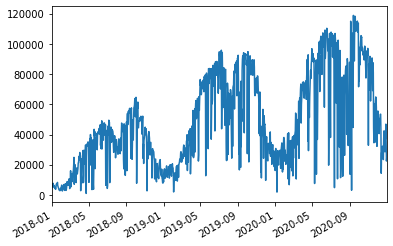

In [55]:
#plt.figure(figsize=(15,6))
time_series(train).plot()

### 정상성 확인(차분 필요여부)

In [6]:
# pmdarima 패키지에 있는 ADFTest 클래스를 임포트
from pmdarima.arima import ADFTest

# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(time_series(train))
print('p_val : %f , should_diff : %s' %(p_val, should_diff))

p_val : 0.218787 , should_diff : True


### 파이썬에서 R 시계열 패키지 forecast를 통한 모델링

In [166]:
from rpy2.robjects.packages import importr # rpy2 내의 패키지를 불러올 importr 클래스

utils = importr('utils') # utils 패키지를 임포트
utils.install_packages('forecast') # r의 forecast 패키지 설치.
utils.install_packages('forecastHybrid') # r의 forecastHybrid 패키지 설치


ModuleNotFoundError: No module named 'rpy2'

In [18]:
utils.install_packages('Zoo')

rpy2.rinterface.NULL

In [37]:
%%time
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=365) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('rental') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
#zoo = robjects.r('zoo')

start_year = int(min(train['date'])[:4]) # 영업 시작 년도
start_month = int(min(train['date'])[5:7]) # 영업 시작 월
    
# R의 ts 함수로 r의 time series 자료형으로 변환
train = ts(train['rental'], start=c(start_year, 0), frequency=365) 

#ensemble model
forecast = auto_arima(train)
a = (pandas2ri.ri2py(forecast).values) # 3개월 매출을 합산

C:\Users\HOME\anaconda3\envs\dankook\lib\site-packages\rpy2-2.9.4-py3.7-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


array([[ 39933.10411361,  13637.0960067 ,  66229.11222053,
          -283.16982525,  80149.37805248],
       [ 42188.28994381,  14296.49793224,  70080.08195539,
          -468.52487092,  84845.10475855],
       [ 37130.67852744,   9094.15804744,  65167.19900745,
         -5747.47937897,  80008.83643385],
       ...,
       [ 47758.05378832,   8751.00021173,  86765.10736491,
        -11898.08663444, 107414.19421108],
       [ 34499.05378832,  -4531.8832869 ,  73529.99086354,
        -25193.61329353,  94191.72087017],
       [ 36546.05378832,  -2508.75217986,  75600.8597565 ,
        -23183.11761518,  96275.22519182]])

In [45]:
%%time
a = (pandas2ri.ri2py(forecast).values)
a.shape
a = a.mean(axis=1)
a

Wall time: 1.41 ms


array([ 39933.10411361,  42188.28994381,  37130.67852744,  34717.09634585,
        26958.11822573,  13556.55226067,  33209.39453015,  40442.43062743,
        41164.45484698,  35048.31274316,  31672.70097892,  38641.22868614,
        40311.42062058,  40285.73049888,  40936.55026345,  41550.21856802,
        36571.02800686,  29628.23138259,  40566.04711697,  42580.66392681,
        44980.24486377,  46440.93080476,  31209.84346766,  27217.08801696,
        34672.75531494,  28826.92386678,  44091.66150108,  49986.02682188,
        50077.07046317,  47856.8361728 ,  39152.36174899,  34386.67984947,
        41684.81869058,  35010.80265128,  32316.65279504,  34407.38732073,
        38547.0219522 ,  34053.5702749 ,  33107.04402666,  45964.45334901,
        52571.80700423,  22707.11256296,  46384.37656623,  53238.60466551,
        41846.80174369,  18807.97201958,  25787.11913825,  31783.24624903,
        44731.35607297,  48037.45096104,  41789.5329445 ,  30300.60377836,
        37169.66497893,  

In [46]:
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = a
submission.to_csv('./output/dankook/dankook1.csv', index=False)
submission

date        rental
0    2021-01-01  39933.104114
1    2021-01-02  42188.289944
2    2021-01-03  37130.678527
3    2021-01-04  34717.096346
4    2021-01-05  26958.118226
..          ...           ...
360  2021-12-27  49114.053788
361  2021-12-28  58923.053788
362  2021-12-29  47758.053788
363  2021-12-30  34499.053788
364  2021-12-31  36546.053788

[365 rows x 2 columns]

###  시계열 모델 선택과 검증
#### 자기회귀누적이동평균 모델

#### 지수평활법

In [56]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=365) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

    
# R의 ts 함수로 r의 time series 자료형으로 변환
ts_train2 = ts(train['rental'], start=c(2018, 0), frequency=365) 

#ensemble model
forecast = auto_arima(ts_train2)
b = (pandas2ri.ri2py(forecast).values) # 3개월 매출을 합산

In [57]:
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = b
submission.to_csv('./output/dankook/dankook2.csv', index=False)
submission

date        rental
0    2021-01-01  39933.104114
1    2021-01-02  42188.289944
2    2021-01-03  37130.678527
3    2021-01-04  34717.096346
4    2021-01-05  26958.118226
..          ...           ...
360  2021-12-27  49114.053788
361  2021-12-28  58923.053788
362  2021-12-29  47758.053788
363  2021-12-30  34499.053788
364  2021-12-31  36546.053788

[365 rows x 2 columns]

#### STL 분해를 적용한 지수평활법

C:\Users\HOME\anaconda3\envs\dankook\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


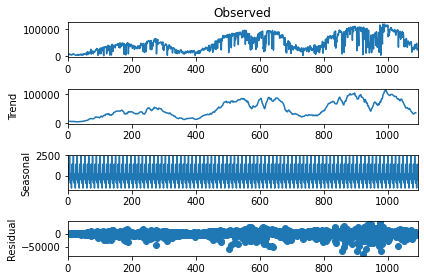

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

t_train = time_series(train)
# STL 분해
stl = seasonal_decompose(t_train.values, freq=12)
stl.plot()
plt.show()

In [59]:
%%time

import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈

# pandas2ri를 활성화 
pandas2ri.activate()
stlm = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = stlm(ts, s.window="periodic", method='ets') # STL 분해 후 지수평활법을 통한 예측 
        forecasted_data = forecast(model, h=365) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=365) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""
# r() 함수로 r을 파이썬에서 사용 가능
stlm = robjects.r(stlm)# str 형식으로 정의된 stlm
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

# R의 ts 함수로 r의 time series 자료형으로 변환
ts_train3 = ts(train['rental'], start=c(2018, 0), frequency=365) 

#ensemble model
forecast = auto_arima(ts_train3)
c = (pandas2ri.ri2py(forecast).values) # 3개월 매출을 합산

Wall time: 39min 30s


In [60]:
submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = c
submission.to_csv('./output/dankook/dankook3.csv', index=False)
submission

date        rental
0    2021-01-01  39933.104114
1    2021-01-02  42188.289944
2    2021-01-03  37130.678527
3    2021-01-04  34717.096346
4    2021-01-05  26958.118226
..          ...           ...
360  2021-12-27  49114.053788
361  2021-12-28  58923.053788
362  2021-12-29  47758.053788
363  2021-12-30  34499.053788
364  2021-12-31  36546.053788

[365 rows x 2 columns]

<AxesSubplot:>

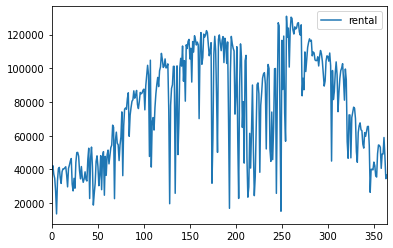

In [61]:
submission.plot()

## 성능 향상을 위한 방법
###  상점 매출액의 로그 정규화

In [51]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
import numpy as np

# pandas2ri를 활성화 
pandas2ri.activate()

auto_arima = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        d_params = ndiffs(ts) # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params) # auto.arima 모델 생성
        forecasted_data = forecast(model, h=365) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log')# 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

# 0번 상점 추출
store_0 = resampling_data[resampling_data['store_id']==0]
start_year = int(min(store_0['year_month'])[:4]) # 영업 시작 년도
start_month = int(min(store_0['year_month'])[5:]) # 영업 시작 월

# train, test 분리
train = store_0[store_0.index <= len(store_0)-4]
test = store_0[store_0.index > len(store_0)-4]

# R의 ts 함수로 r의 time series 자료형으로 변환
train_log = ts(log(train['amount']), start=c(start_year, start_month), frequency=12) # log 정규화 
train = ts(train['amount'], start=c(start_year, start_month), frequency=12) # log 정규화를 하지 않음

# model arima
forecast_log = auto_arima(train_log)
forecast = auto_arima(train)

# pred
pred_log = np.sum(pandas2ri.ri2py(exp(forecast_log)).values) #로그 역변환 후 3개월 합산
pred = np.sum(pandas2ri.ri2py(forecast).values) #3개월 매출을 합산

# test(2018-12~2019-02)
test = np.sum(test['amount'])

# mae
print('log-regularization mae: ', abs(test-pred_log))
print('mae:', abs(test-pred))

log-regularization mae:  2401.9664819482714
mae: 25197.053143496625


In [52]:
# 매출 변동 계수를 구하는 함수
def coefficient_variation(df, i):
    cv_data = df.groupby(['store_id']).amount.std()/df.groupby(['store_id']).amount.mean()
    cv = cv_data[i]
    return cv

In [53]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
import numpy as np

# pandas2ri를 활성화 
pandas2ri.activate()

ets = """
    function(ts){
        library(forecast) # forecast 패키지 로드
        model = ets(ts) # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3) # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean) # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount') # amount라는 열로 이름을 지정
        out_df
    }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    
    cv = coefficient_variation(resampling_data, i)
    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        train_log = ts(log(store['amount']), start=c(start_year,start_month), frequency=12) 
        # ets model
        forecast_log = ets(train_log)
        final_pred.append(np.sum(pandas2ri.ri2py(exp(forecast_log)).values))
    # 매출액 변동 계수가 0.3 이상인 경우
    else:
        train = ts(store['amount'], start=c(start_year,start_month), frequency=12)
        # 지수평활법
        forecast = ets(train)
        final_pred.append(np.sum(pandas2ri.ri2py(forecast).values)) 

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [48:06<00:00,  1.47s/it]


In [54]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission4.csv', index=False)
submission

store_id        amount
0            0  1.963401e+06
1            1  2.483335e+05
2            2  1.260318e+06
3            4  2.660373e+06
4            5  7.091162e+05
...        ...           ...
1962      2132  2.122653e+06
1963      2133  3.488475e+05
1964      2134  4.249576e+05
1965      2135  1.603989e+06
1966      2136  6.504026e+06

[1967 rows x 2 columns]

### 4.5.2.	파이썬에서 R 시계열 패키지 forecastHybrid를 통한 앙상블

In [55]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
import numpy as np

# pandas2ri를 활성화 
pandas2ri.activate()

hybridModel = """
    function(ts){
        library(forecast)
        library(forecastHybrid)
        d_params=ndiffs(ts)
        hb_mdl<-hybridModel(ts, models="aes", # auto_arima, ets, stlm
                        a.arg=list(max.p=2, d=d_params), # auto_arima parameter
                        weight="equal") # 가중치를 동일하게 줌(평균)
        forecasted_data<-forecast(hb_mdl, h=365) # 이후 3개월(h=3)을 예측
        outdf<-data.frame(forecasted_data$mean)
        colnames(outdf)<-c('rental')
        outdf
    }
""" 

# r() 함수로 r 자료형을 파이썬에서 사용 가능
hybridModel = robjects.r(hybridModel)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

final_pred = []

# R의 ts 함수로 r의 time series 자료형으로 변환
ts_train2 = ts(train['rental'], start=c(2018, 0), frequency=365) 

#ensemble model
forecast = hybridModel(ts_train2)
b = (pandas2ri.ri2py(forecast).values) # 3개월 매출을 합산

submission = pd.read_csv('./input/dankook/sample_submission.csv')
submission['rental'] = b
submission.to_csv('./output/dankook/dankook5.csv', index=False)
submission

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [38:40<00:00,  1.18s/it]


In [57]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred
submission.to_csv('submission5.csv', index=False)
submission

store_id        amount
0            0  1.973673e+06
1            1  2.700469e+05
2            2  1.279552e+06
3            4  2.695279e+06
4            5  8.240620e+05
...        ...           ...
1962      2132  2.115933e+06
1963      2133  6.311052e+05
1964      2134  3.021292e+05
1965      2135  1.626442e+06
1966      2136  6.504046e+06

[1967 rows x 2 columns]